# Приоритизация гипотез и анализ А/В-теста для интернет-магазина

**Заказчик:** отдел маркетинга.

**Цель:** приоритизировать гипотезы для увеличения выручки, запустить A/B-тест и проанализировать результаты. 

**Предпосылки:** 
- вместе с отделом маркетинга мы подготовили список из 9 гипотез для увеличения выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort, файл с гипотезами: /datasets/hypothesis.csv;
- результаты A/B-теста описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

**Описание данных**

Структура файла /datasets/hypothesis.csv:

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

Структура файла /datasets/orders.csv:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.


Структура файла /datasets/visitors.csv: 

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

**План работы**

1. Загрузка, обзор и предобработка данных


2. Приоритизация гипотез

- с помощью фреймворка ICE,
- с помощью фреймфорка RICE.

3. Анализ A/B-теста

- кумулятивная выручка и средний чек по группам, изменение кумулятивного среднечего чека в зависимости от группы,
- кумулятивное среднее количество заказов на посетителя по группам, относительное изменение кумулятивного среднего количества заказов,
- точечный график количества заказов по пользователям,
- перцентили количества заказов на пользователя и стоимости заказов, выбор границ для определения аномальных значений,
- статистическая значимость различий в среднем количестве заказов на посетителя, в среднем чеке заказа между группами по "сырым" и "очищенным" данным,
- решение по результатам теста.


### Загрузка, обзор и предобработка данных

Импортируем Пандас и необходимые для работы библиотеки:

In [1]:
import pandas as pd
import scipy.stats as stats
from scipy import stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import seaborn as sns

pd.set_option('display.max_columns', None) # снимем ораничение на количетсво отображаемых столбцов
pd.set_option('display.max_colwidth', None) # снимем ограничение на ширину столбцов

plt.rcParams['figure.figsize'] = [20, 10] # установим одинаковый размер для всех графиков в документе

Загружаем данные о визитах, заказах и пользователях из CSV-файлов в переменные:

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

Посмотрим на загруженные данные о гипотезах:

In [3]:
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


С файлом с гипотезами все хорошо, пропусков нет, форматы в порядке. Можно только привести написание наименований столбцов полностью к нижнему регистру - без первой большой буквы. 

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Посмотрим на датафрейм с заказами:

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [7]:
orders.tail(10)

,transactionId,visitorId,date,revenue,group
1187,2274188238,132143192,2019-08-14,750,A
1188,1692103379,1022829655,2019-08-14,112,A
1189,4082620617,393266494,2019-08-14,31550,B
1190,38478481,1197745035,2019-08-14,8600,B
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A
1196,3936777065,2108080724,2019-08-15,202740,B


In [8]:
orders.sample(10)

,transactionId,visitorId,date,revenue,group
798,2291957725,2188683977,2019-08-05,5719,A
886,51443164,4278982564,2019-08-05,24744,A
717,1946569610,3693438260,2019-08-27,3590,A
1111,2358087265,2115669947,2019-08-12,7500,A
182,3221239900,522292794,2019-08-23,778,B
424,2609443403,2406916810,2019-08-19,470,B
859,549358396,3792964032,2019-08-10,2970,A
912,437876380,39475350,2019-08-08,3990,B
1124,86504917,3598591418,2019-08-13,6780,A
65,2321477056,2868887864,2019-08-16,1710,B


Необходимо изменить формат столбца с датой - с object на datetime:

In [9]:
orders['date'] = pd.to_datetime(orders['date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


И подправить написание названий столбцов transactionId и visitorId на более легко воспринимаемые transaction_id и visitor_id соответственно:

In [10]:
orders = orders.rename(columns= {'transactionId' : 'transaction_id',
                                'visitorId' : 'visitor_id'})
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Теперь все в порядке. И смотрим на последний датафрейм в переменной visitors.

In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
visitors.tail(5)

,date,group,visitors
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490
61,2019-08-31,B,718


In [14]:
visitors.sample(5)

,date,group,visitors
30,2019-08-31,A,699
54,2019-08-24,B,378
49,2019-08-19,B,487
33,2019-08-03,B,509
22,2019-08-23,A,468


Здесь также необходимо изменить формат столбца 'date':

In [15]:
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Форматы изменили. Теперь проверим датафреймы на дубликаты:

In [16]:
hypothesis.duplicated().sum()

0

In [17]:
orders.duplicated().sum()

0

In [18]:
visitors.duplicated().sum()

0

Убедимся, что в нашем А/В-тесте 2 группы:

In [19]:
visitors['group'].nunique()

2

Посмотрим в какие даты проводился тест:

In [20]:
visitors['date'].min()

Timestamp('2019-08-01 00:00:00')

In [21]:
visitors['date'].max()

Timestamp('2019-08-31 00:00:00')

Получается, с 1 по 31 августа 2019 года.

Посчитаем количество пользователей в группах:

In [22]:
users_a = orders[orders['group']=='A']
users_b = orders[orders['group']=='B']

In [23]:
users_a['visitor_id'].count()

557

In [24]:
users_b['visitor_id'].count()

640

Посетителей из группы В больше, но сделать однозначный вывод о несбалансированности групп нельзя, поскольку данные мы берем из таблицы с заказами и на эти цифры могла повляить разная конверсия в группах.

**Вывод**

Файлы прочитаны. Пропусков и дубликатов в датафреймах нет.

Форматы столбцов с датами не соответствоали содержимому - у столбцов date в visitors и orders был формат object, в ходе предобработки данных привели эти столбцы к формату datetime. Также привели написание наименований столбцов в hypothesis и orders к нижнему регистру.

А/В-тестирование проходило с 1 по 31 августа 2019 года. Все в тесте участвовало две группы: в группе А было 557 пользователей, в группе В - 640. О несбалансированности групп здесь говорить нельзя, поскольку на эти цифры могла повлиять разная конверсия в группах.

Можно приступать к работе по приоритизации гипотез.

### Приоритизация гипотез

Сначала применим фреймворк ICE для приоритизации гипотез и отсортируем их по убыванию приоритета:

In [25]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'] 

hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(2)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


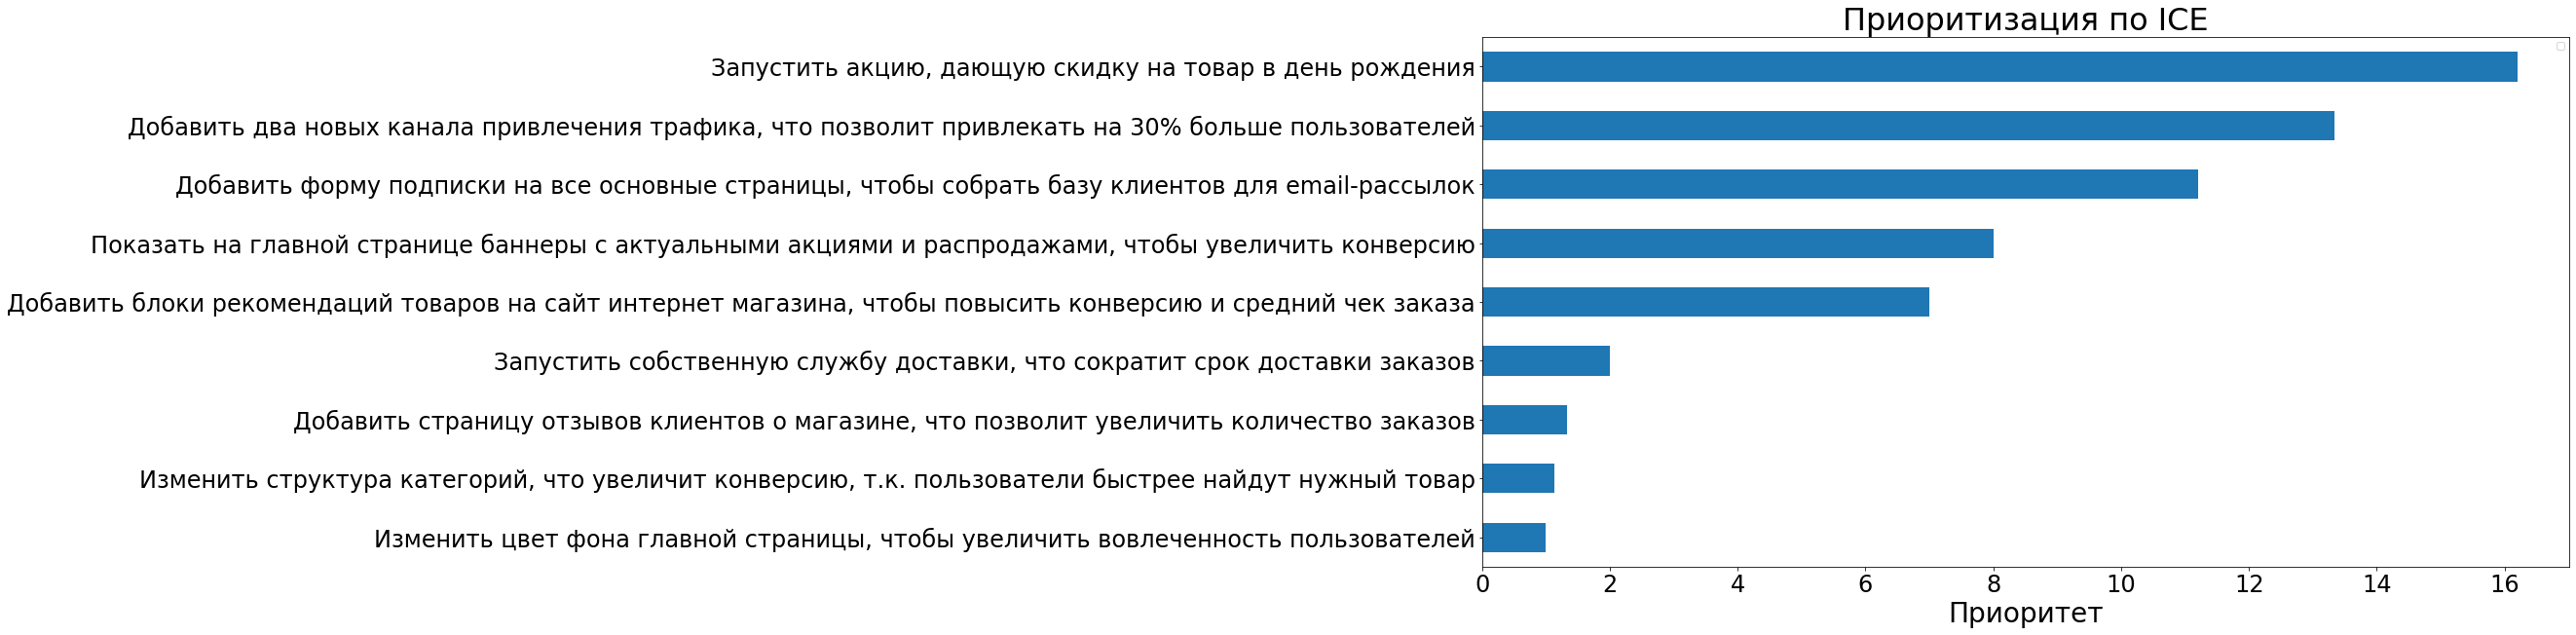

In [26]:
plt.rc('ytick', labelsize= 24)
plt.rc('xtick', labelsize= 24)

(hypothesis[['hypothesis','ICE']]
.set_index('hypothesis')
.sort_values(by='ICE', ascending=True)
.plot(kind='barh', stacked= True))

plt.title('Приоритизация по ICE',fontsize=32)
plt.xlabel('Приоритет', fontsize=28)
plt.ylabel('')
plt.legend('')
plt.show()

In [27]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'] 

hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


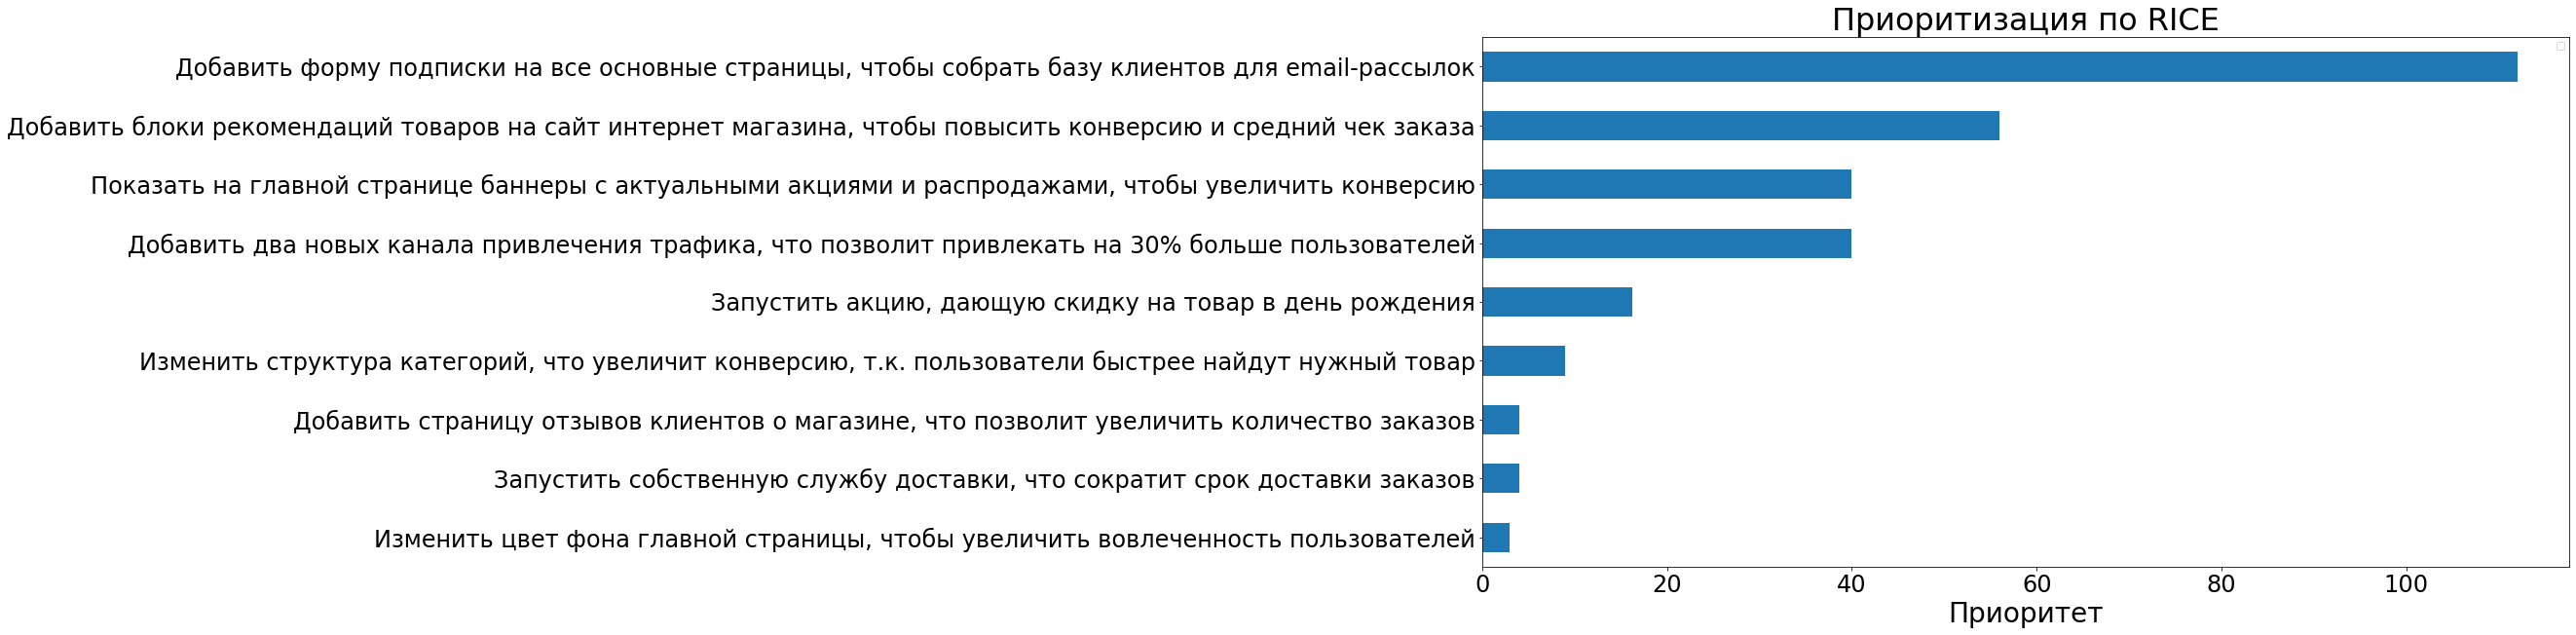

In [28]:
(hypothesis[['hypothesis','RICE']]
.set_index('hypothesis')
.sort_values(by='RICE', ascending=True)
.plot(kind='barh', stacked= True))

plt.title('Приоритизация по RICE',fontsize=32)
plt.xlabel('Приоритет', fontsize=28)
plt.ylabel('')
plt.legend('')
plt.show()

Выведем таблицу с результатами приоритизации и по ICE, и по RICE.

In [29]:
hypothesis.sort_values('RICE', ascending=False).round(2)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


**Вывод:**

Результаты отличаются только из-за дополнительного параметра reach во фреймворке RICE, то есть от охвата пользователей.

Видим, что по ICE самые перспективные гипотезы - Запустить акцию, дающую скидку на товар в день рождения; Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей; Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. 

По RICE - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок; Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа; Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей; Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

### Анализ A/B-теста

Проанализируем А/В-тест, результаты которого хранятся в переменных orders и visitors.

Чтобы исключить проблему подсматривания из тестирования, проанализируем графики кумулятивных метрик.

**Кумулятивные метрики**

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм cumulative_data со столбцами: 
- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

Сначал создадим массив уникальных пар значений дат и групп теста методом drop_duplicates(): 

In [30]:
dates_groups = orders[['date','group']].drop_duplicates() 

Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий: 
- получим строки таблицы orders, дата которых меньше или равна дате элемента из dates_groups, а группа теста равна группе из dates_groups, 
- далее агрегируем значения и вычислим максимальную дату, 
- для группы тоже рассчитаем максимум, чтобы столбец 'group' не пропал из итогового вывода,
- найдём число уникальных ID заказов и пользователей,
- подсчитаем сумму средних чеков:

In [31]:
orders_aggregated = (
    dates_groups
.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                       orders['group'] == x['group'])]
       .agg({'date' : 'max', 
             'group' : 'max', 
             'transaction_id' : 'nunique', 
             'visitor_id' : 'nunique', 
             'revenue' : 'sum'}), axis=1)
.sort_values(by=['date','group'])
)
orders_aggregated.head(10)

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
310,2019-08-03,B,61,59,380996
499,2019-08-04,A,84,77,425699
498,2019-08-04,B,78,75,489567
698,2019-08-05,A,109,100,549917
699,2019-08-05,B,101,98,581995


Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина: 

In [32]:
visitors_aggregated = (
    dates_groups
    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                             visitors['group'] == x['group'])]
           .agg({'date' : 'max', 
                 'group' : 'max', 
                 'visitors' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)
visitors_aggregated.head(10)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
310,2019-08-03,B,1803
499,2019-08-04,A,2562
498,2019-08-04,B,2573
698,2019-08-05,A,3318
699,2019-08-05,B,3280


Объединим обе таблицы в одну cumulative_data с понятными названиями столбцов, указанными выше: 


In [33]:
cumulative_data = (
    orders_aggregated
    .merge(visitors_aggregated, left_on=['date', 'group'], 
           right_on=['date', 'group'])
)

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


Проверим корректно ли создан датафрейм cumulative_date, для этог посмотрим на минимальную и максимальную даты в столбце date. 

In [34]:
cumulative_data['date'].min()

Timestamp('2019-08-01 00:00:00')

In [35]:
cumulative_data['date'].max()

Timestamp('2019-08-31 00:00:00')

Даты 31 и 1 августа 2019 года, значит, датафрейм создан корректно.

**Построим графики кумулятивной выручки по дням и группам A/B-тестирования:** 


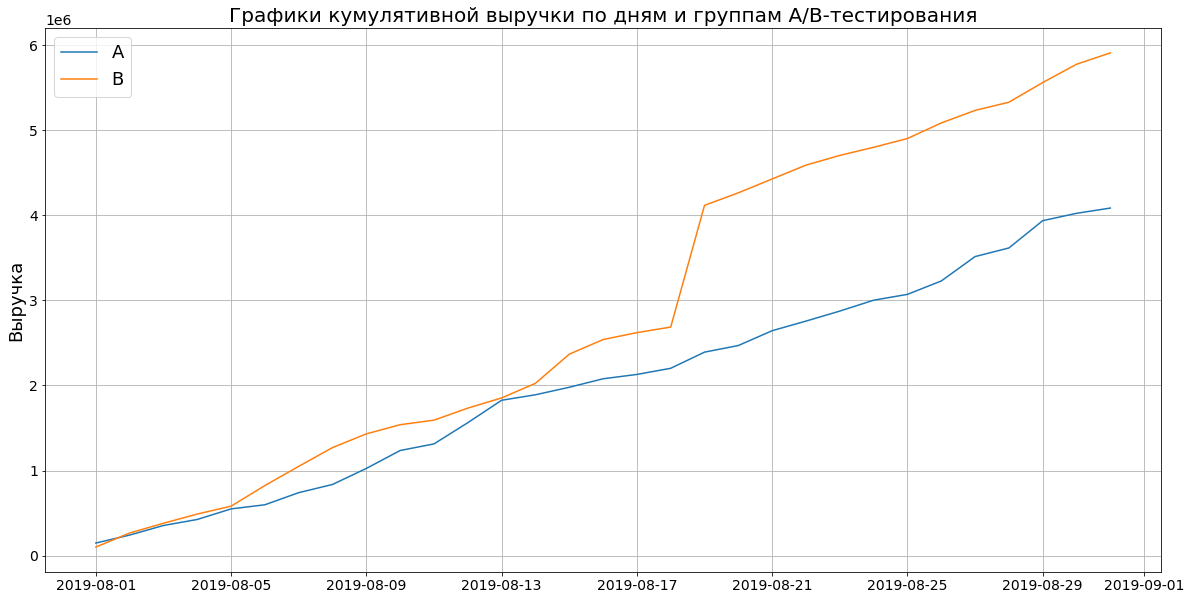

In [36]:
# предварительно увеличим шрифт с подписями данных по осям до 14
plt.rc('xtick', labelsize= 14) 
plt.rc('ytick', labelsize= 14)

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')


plt.title('Графики кумулятивной выручки по дням и группам А/В-тестирования', fontsize=20)
plt.xlabel('')
plt.ylabel('Выручка', fontsize=18)
plt.legend(loc=2, fontsize=18)
plt.grid()
plt.show()


**Вывод**

Видим, что выручка увеличивается в течение всего теста, что является хорошим знаком. Причем выручка в группе В 18 августа 2019 резко увеличилась. Это может говорить о всплеске числа заказов в этот день, либо о появлении очень дорогих заказов в выборке. Это мы проанализурем позднее - на этапе определения аномальных пользователей и заказов.

Итак, идем далее. **Построим график кумулятивного среднего чека по группам.**

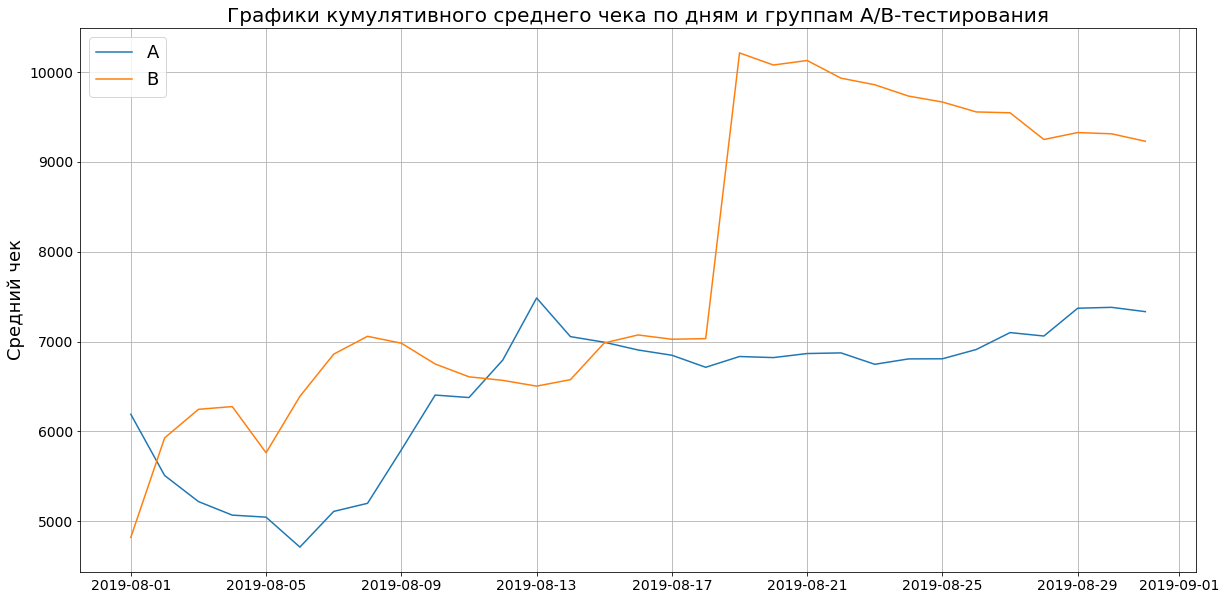

In [37]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.title('Графики кумулятивного среднего чека по дням и группам А/В-тестирования', fontsize=20)
plt.xlabel('')
plt.ylabel('Средний чек', fontsize=18)
plt.legend(loc=2, fontsize=18)
plt.grid()
plt.show()

**Вывод**

График для группы А снчала несколько падает, делает скачок вверх и далее стабилизируется. 

График группы В также в конце стабилизируется, но 18 августа делает резкий скачок, что говорит о том, что, резкий скачок выручки в этот день, скорее, связан с появлением очень дорогого заказа или нескольких заказов.  

Далее **построим график относительного изменения кумулятивного среднего чека группы B к группе A.** 

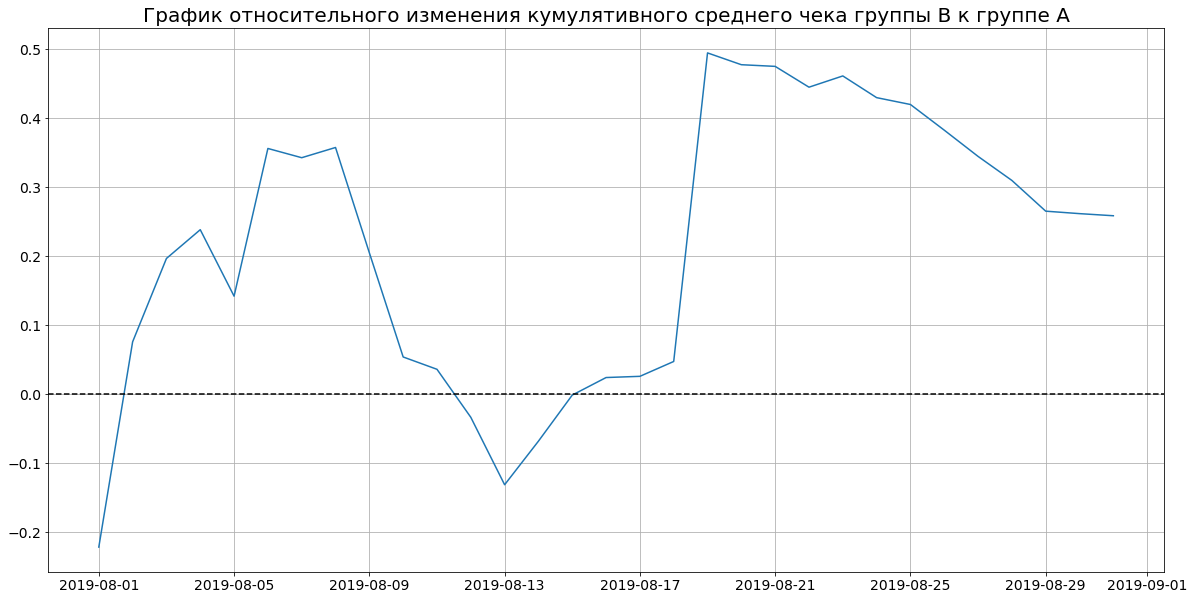

In [38]:
# собираем данные в одном датафрейме
merged_сumulative_revenue = (
    cumulative_revenue_a
    .merge(cumulative_revenue_b, 
           left_on='date', right_on='date', how='left', 
           suffixes=['A', 'B'])
)

# cтроим отношение средних чеков
plt.plot(merged_сumulative_revenue['date'], 
         (merged_сumulative_revenue['revenueB']/merged_сumulative_revenue['ordersB'])/
         (merged_сumulative_revenue['revenueA']/merged_сumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.grid()
plt.show()

**Вывод**

В нескольких точках мы видим скачок графика - особенно это видно все того же 18 августа. Наверняка, это связано с крупными заказами или выбросами. Узнаем это при определении аномальных значений.

**Построим график кумулятивного среднего количества заказов на посетителя по группам.**

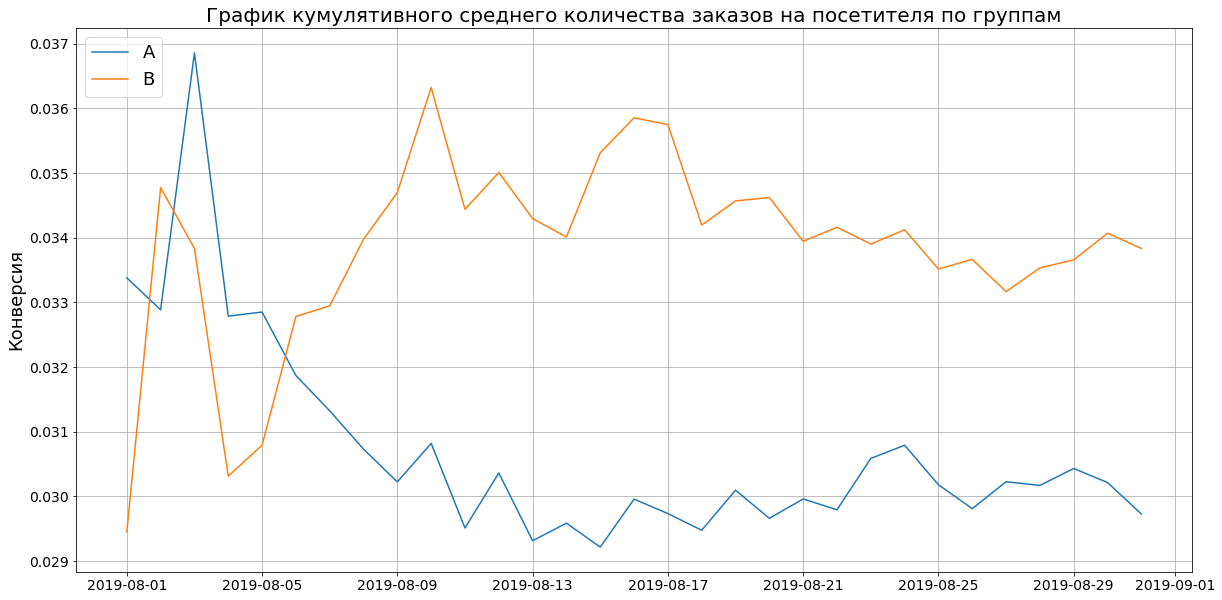

In [39]:
# сначала считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')

plt.title('График кумулятивного среднего количества заказов на посетителя по группам', fontsize=20)
plt.xlabel('')
plt.ylabel('Конверсия', fontsize=18)
plt.legend(loc=2, fontsize=18)
plt.grid()
plt.show()


**Вывод**

График в первые пять дней был неусточив, а затем выравнялся у обоих групп. Конверсия группы В выше. 


Никакого скачка 18 августа на этом графике не наблюдается. Значит, среднее количество заказов в этот день не увеличилось и скачок на предыдущих графиках, скорее, связан с каким-то одним конкретным крупным заказом.

**Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.**

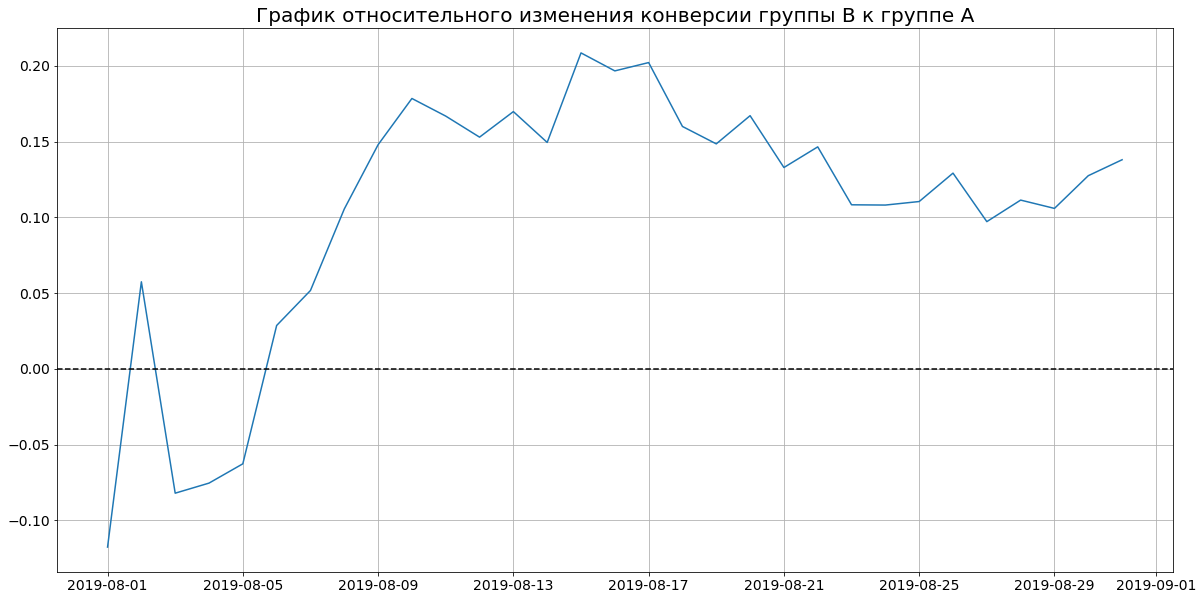

In [40]:
merged_cumulative_conversions = (cumulative_data_a[['date','conversion']]
                                 .merge(cumulative_data_b[['date','conversion']], 
                                        left_on='date', 
                                        right_on='date', 
                                        how='left', 
                                        suffixes=['A', 'B'])
                                )

plt.plot(merged_cumulative_conversions['date'], 
         merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1)


plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения конверсии группы B к группе A', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.grid()
plt.show()

**Вывод**

Конверсия группы А была выше лишь 1 августа и с 3 по 6 августа. После 6-го - конверсия группы В стабильно выше. 
Однако, перед окончательным выводом необхоимо проанализировать аномалии, возможно, это изменит картину.

**Построим график количества заказов по пользователям** 


Подсчитаем количество заказов по пользователям и посмотрим на результат:


In [41]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

orders_by_users.columns = ['visitor_id', 'orders']

orders_by_users.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Есть пользователи, которые совершили по 11 заказов, а еще 9 и 8. Что, кажется, больше, чем средний пользователь.

Построим гистрограмму распределения количества заказов на одного пользователя:

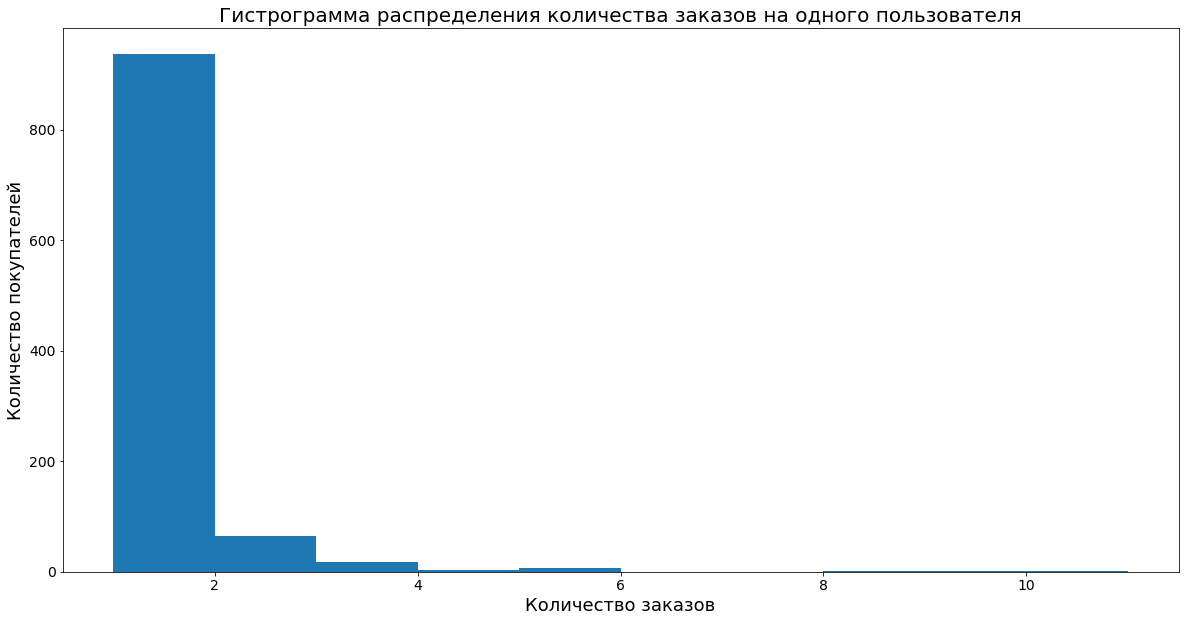

In [42]:
plt.hist(orders_by_users['orders']) 
plt.title('Гистрограмма распределения количества заказов на одного пользователя', fontsize=20)
plt.xlabel('Количество заказов', fontsize=18)
plt.ylabel('Количество покупателей', fontsize=18)
plt.show()

Большинство пользователей сделали 1 заказ, но есть и пользователи с 2 и 3 заказами, хоть их и меньше.

Построим точечную диаграмму числа заказов на одного пользователя:

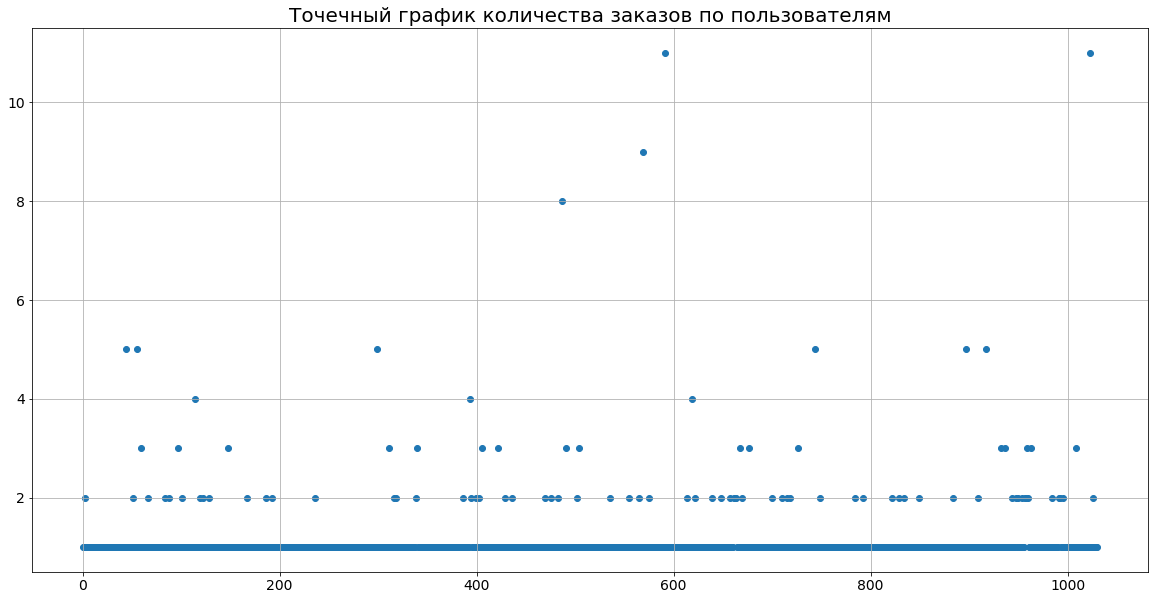

In [43]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders'])

plt.title('Точечный график количества заказов по пользователям', fontsize=20)
plt.grid()
plt.show()

**Вывод**

Выводы подтверждаются: много пользователей с 2-5 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет. Чтобы в этом разобраться посчитаем выборочные перцентили количества заказов на одного пользователя.


**Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.**

In [44]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[2. 4.]


**Вывод** 

Не более 5% пользователей оформляли больше чем 2 заказа. И 1% пользователей заказывали более 4 раз. 
Логично выбрать 4 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

Сделаем это далее, когда будем считать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

**Построим график стоимостей заказов**

Изучим гистограмму распределения стоимостей заказов: 

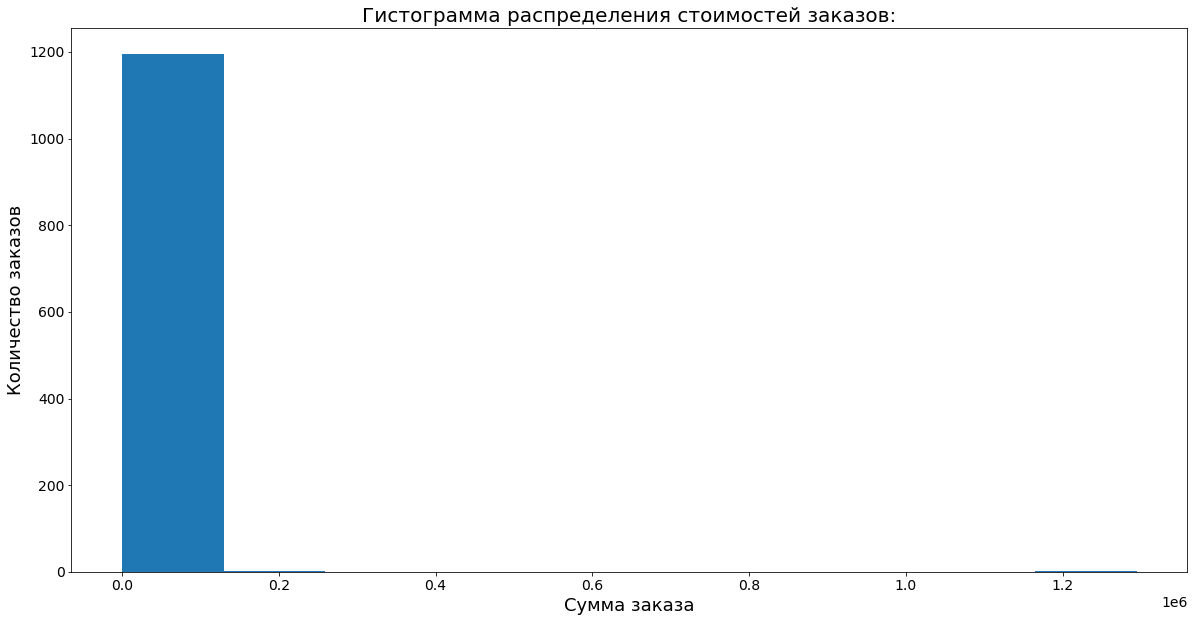

In [45]:
plt.hist(orders['revenue']) 

plt.title('Гистограмма распределения стоимостей заказов:', fontsize=20)
plt.xlabel('Сумма заказа', fontsize=18)
plt.ylabel('Количество заказов', fontsize=18)
plt.show()

Видна сумма заказа в 1,2 млн, в то время как абсолютное большинство заказов в пределах 0,1 млн.

Оценим стоимость заказов ещё с помощью точечного графика:

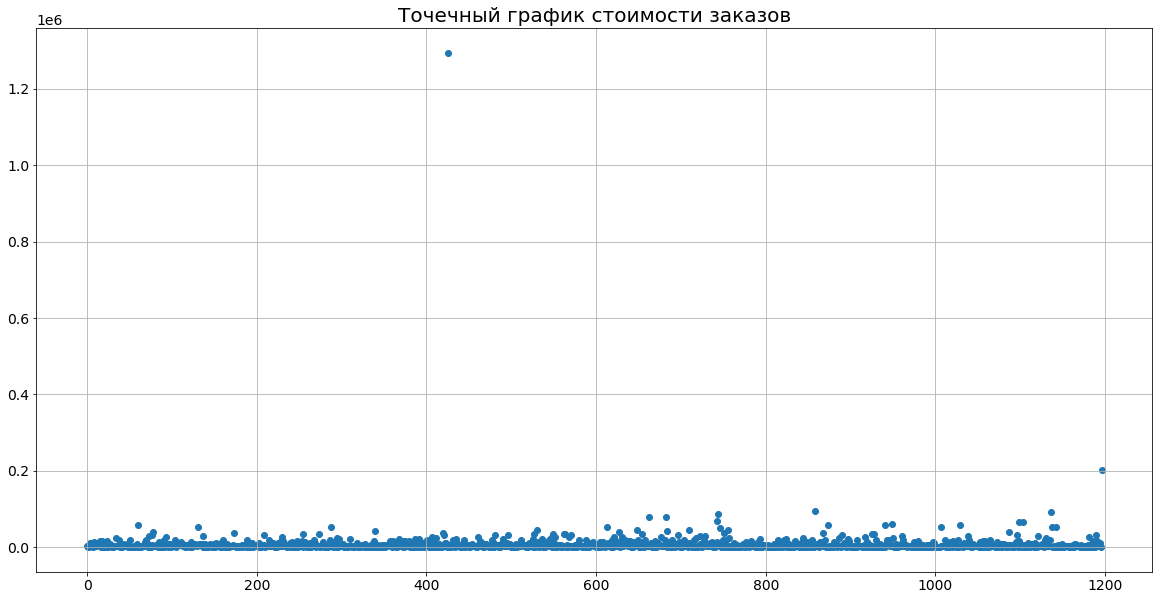

In [46]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.title('Точечный график стоимости заказов', fontsize=20)
plt.grid()
plt.show()

Посмотрим на основную часть заказов, которая лежит в диапазоне до 0.1 млн.:

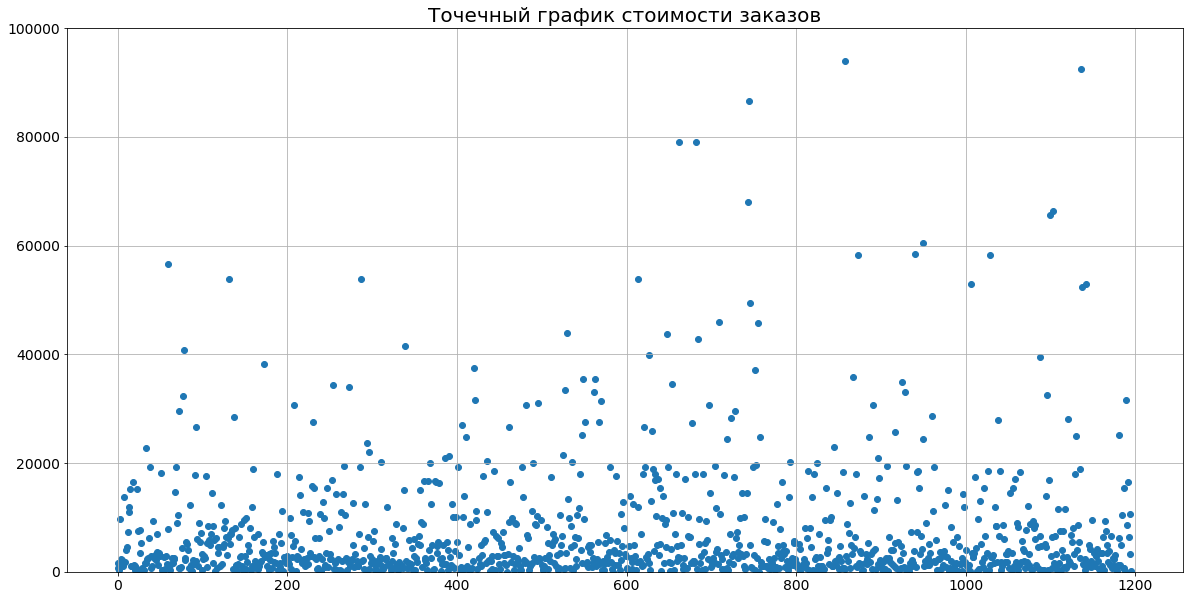

In [47]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.title('Точечный график стоимости заказов', fontsize=20)
plt.ylim([0, 100000])

plt.grid()
plt.show()

**Вывод** 

Как мы и предполагали выше: есть один очень дорогой заказ. И несколько заказов, выбивающихся из общей коллеи, но совсем незначительно. Кажется, что аномальные значения видны уже из графика, но, как и в случае с количеством заказов на одного пользователя, здесь также лучше посчитать выборочные перцентили стоимости заказов, чтобы определить границы аномальных значений. 


**Посчитаем 95-й и 99-й перцентили стоимости заказов**

In [48]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


**Вывод**

Итак, не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 233 рублей. Границу для отсечения аномальных значений установим на сумме 58 233 рубля.

**Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.** 

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

Уровень значимости alpha=0,05.

Подготовим данные:

In [49]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)

orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Названия столбцов данных:
- date — дата;
- orders_per_date_a — количество заказов в выбранную дату в группе A;
- revenue_per_date_a — суммарная выручка в выбранную дату в группе A;
- orders_per_date_b — количество заказов в выбранную дату в группе B;
- revenue_per_date_b — суммарная выручка в выбранную дату в группе B;
- orders_cummulative_a — суммарное число заказов до выбранной даты включительно в группе A;
- revenue_cummulative_a — суммарная выручка до выбранной даты включительно в группе A;
- orders_cummulative_b — суммарное количество заказов до выбранной даты включительно в группе B;
- revenue_cummulative_b — суммарная выручка до выбранной даты включительно в группе B;
- visitors_per_date_a — количество пользователей в выбранную дату в группе A;
- visitors_per_date_b — количество пользователей в выбранную дату в группе B;
- visitors_cummulative_a — количество пользователей до выбранной даты включительно в группе A;
- visitors_cummulative_b — количество пользователей до выбранной даты включительно в группе B.

Посчитаем статистическую значимость различия в среднем количестве заказов между группами.
Создадим переменные orders_by_users_a и orders_by_users_b со столбцами ['user_id', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [50]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders']

Объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [51]:
sample_a = (pd.concat([orders_by_users_a['orders'],
                      pd.Series(0, index=np.arange(data['visitors_per_date_a']
                                                   .sum() - len(orders_by_users_a['orders'])), 
                                name='orders')],
                     axis=0)
           )

sample_b = (pd.concat([orders_by_users_b['orders'],
                      pd.Series(0, index=np.arange(data['visitors_per_date_b']
                                                   .sum() - len(orders_by_users_b['orders'])), 
                                name='orders')],
                     axis=0)
           )


Применим критерий Манна-Уитни и отформатируем p-value, округлив его до трёх знаков после запятой:

In [52]:
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print('Различие в средних:', "{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

p-value: 0.017
Различие в средних: 0.138


**Вывод** 

По «сырым» данным различие в среднем числе заказов между группами A и B есть. 
Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 13.8% — второе число в выводе.

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.**

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. 

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

Уровень статистической значимости alpha=0.05.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. 
А ещё найдём относительные различия в среднем чеке между группами:

In [53]:
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']
                                          ['revenue'], orders[orders['group']=='B']['revenue'])[1]))

print('Различие в средних:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()
                       /orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.729
Различие в средних: 0.259


**Вывод**

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Но при этом средний чек группы B значительно выше среднего чека группы A - аж на 25.9%.

**Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.**

Итак, найденные в прошлых уроках 95-й и 99-й перцентили количества заказов и средних чеков позволили выделить границы аномальных значений. Это более 4 заказов и чек выше 58 233 рублей.

Сделаем срезы пользователей с числом заказов больше 4 — users_with_many_orders и пользователей, совершивших заказы дороже 58 233 — users_with_expensive_orders. Объединим их в таблице abnormal_users.

Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [54]:
orders_by_users_a

,user_id,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1
...,...,...
498,4243832526,1
499,4256040402,7
500,4259830713,1
501,4266935830,1


In [55]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 4]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 4]['user_id'],
    ],
    axis=0,
)

users_with_expensive_orders = orders[orders['revenue'] > 58233]['visitor_id']

abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormal_users.head(5))

print(abnormal_users.shape[0])

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
dtype: int64
15


Всего 15 аномальных пользователей. 
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [56]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:


In [57]:
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Различие в средних:', '{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

p-value: 0.014
Различие в средних: 0.153


**Вывод**

После очистки данных результат не сильно изменился. 

По очищенным данным различие в среднем числе заказов между группами A и B есть. 

Первое число — p-value = 0.014 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. 

Относительный выигрыш группы B равен 15.3% — немного вырос по сравнению с сырыми данными.

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.**

Результаты по среднему количеству заказов практически не изменились. Посмотрим произошло ли что-нибудь с результатами по среднему чеку.

In [58]:
print('p-value:', 
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Различие в средних:', 
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.851
Различие в средних: -0.006


**Вывод**

P-value только увеличился, поэтому причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, по-прежнему нет.
Но мы видим, что теперь средний чек группы B стал даже ниже среднего чека группы A - на 0.6%.


### Общие выводы

- Cамые перспективные гипотезы по фреймворку ICE:
1. запустить акцию, дающую скидку на товар в день рождения; 
2. добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей; 
3. добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

- Самые перспективные гипотезы по фреймфорку RICE, которые также учитывают и охват пользователей:
1. добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок; 
2. добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа; 
3. добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей; 
4. показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

- Статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по «очищенным» данным после фильтрации аномалий есть. Относительный выигрыш группы B равен 13.8% до фильтрации, и 15,3% - после.


- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. При этом до фильтрации средний чек группы В был выше на 25,9%, чем у группы А, после фильтрации - ниже на 0,06%.


- График относительного изменения конверсии группы B к группе A показывает, что конверсия группы В стабильно выше. 


- Исходя из обнаруженных фактов, тест следует остановить, признать его успешным и зафиксировать победу группы B.